In [1]:
import pandas as pd
import numpy as np
import import_ipynb
import utils_cdt as cdt
from datetime import datetime
from pyspark.sql import SparkSession, Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel 
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
import matplotlib.pyplot as plt
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils_cdt.ipynb


In [2]:
infoDataBases = {"ip":"","base":""}

In [3]:
preditoras = ['ParcelasNaoFinanciaveis','SaldoAtualFinal','BaseCalculo','TotalComprasSaques','SaldoExtratoAnterior','valoriof']
prevista = ['ValorMinimoExtrato']

In [4]:
def cache(self): 
    """ 
    Persist this RDD with the default storage level (C{MEMORY_ONLY_SER}). 
    """ 
    self.is_cached = True 
    self.persist(StorageLevel.MEMORY_ONLY_SER) 
    return self 

In [5]:
spark = SparkSession \
    .builder \
    .appName("Modelo - Spark") \
    .config("spark.executor.memory", "4gb") \
    .config("spark.driver.host","127.0.0.1") \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Modelo - Spark>

In [6]:
#Consulta de BASE SQL Server
consulta = cdt.resultQuery("mdl_contas_saldos.sql")
df = cdt.extrairDados(infoDataBases,consulta,arquivo="mdl_contas_saldo_"+infoDataBases["base"]+".csv",spark=False,objSpark=spark)

### [preperTreinoTeste] - preparada dados de acordo com as preditos x alvos para gerar dados de treino e teste

In [7]:
def preperTreinoTeste(df, preditoras, prevista, split):
    # Seleção de variáveis preditoras (Feature Selection)
    atributos = preditoras
    # Variável a ser prevista
    atrib_prev = prevista

    # Criando objetos
    X = np.absolute(df[atributos].values)
    Y = df[atrib_prev].values


    # Definindo a taxa de split
    split_test_size = split
    # Criando dados de treino e de teste
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = split_test_size, random_state = 42)

    Y_treino = Y_treino.astype(int)
    Y_teste  = Y_teste.astype(int)
    
    return X_treino, Y_treino, X_teste, Y_teste


### [runAllModels] - gera varios modelos para avaliar posteriormente eficacia de ambos

### [transformDataSet] - Transforma dois arrays em colunas Previsto X Real

In [8]:
def transformDataSet(previsto, real):
    d = {"Previsto": [x[0] for x in previsto], "Real":[x[0] for x in real]}
    df_resultado = pd.DataFrame(data=d)
    df_resultado['diff'] = df_resultado.Previsto - df_resultado.Real
    df_resultado['porcen'] =  np.absolute(((df_resultado.Previsto / df_resultado.Real)*100)-100)
    df_resultado = df_resultado.round(2)
    return df_resultado

### [getresultdataset] - Printa os totais previsto x reais x diferença x porcentagem

In [9]:
def getresultdataset(dt, model_name):
    total_diff = dt.aggregate(['sum'])['diff'][0]
    total_real = dt.aggregate(['sum'])['Real'][0]
    total_prev = dt.aggregate(['sum'])['Previsto'][0]
    print("["+model_name+"] - Total Real:  %.2f" %(total_real))
    print("["+model_name+"] - Total Prev:  %.2f" %(total_prev))
    print("["+model_name+"] - Total Diff:  %.2f" %(total_diff))
    print("["+model_name+"] - Total Porcentagem de diferença do previsto x real:  {:.2f}%".format(np.absolute(((total_diff / total_real)*100))))

In [10]:
X_treino, Y_treino, X_teste, Y_teste = preperTreinoTeste(df, preditoras, prevista, split = 0.3)

In [11]:
randomForestRegression = RandomForestRegressor().fit(X_treino, Y_treino)

Text(0.5, 1.0, 'Importância de cada feature')

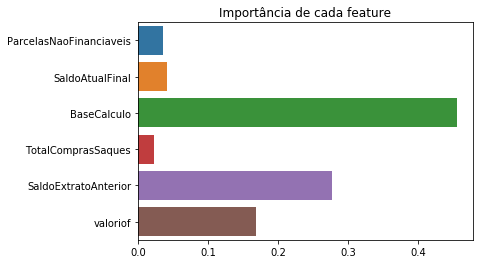

In [12]:
import seaborn as sns
importances = pd.Series(data=randomForestRegression.feature_importances_, index=preditoras)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [13]:
#from sklearn.feature_selection import RFE
#rfe = RFE(randomForestRegression, step=1).fit(X_treino, Y_treino)

In [13]:
randomForestRegression.score(X_teste,Y_teste)

0.8487006041525906

In [15]:
#rfe.score(X_teste,Y_teste)

In [16]:
filename = 'models/mdl_saldo_minimoExtrato.sav'
pickle.dump(randomForestRegression, open(filename, 'wb'))

## Prevendo novos valores com base no Modelo treinado anteriormente

In [17]:
#Carregando modelo 
model_forest = pickle.load(open('models/mdl_saldo_minimoExtrato.sav', 'rb'))

In [18]:
#Consulta de BASE SQL Server
infoDataBases = {"ip":"AZ2D-MASKDB-222.DEVCDT.COM.BR","base":"Controly"}
consulta = cdt.resultQuery("contas_saldos.sql")
df = cdt.extrairDados(infoDataBases,consulta,arquivo="contas_saldo_"+infoDataBases["base"]+".csv",spark=False,objSpark=spark)

In [19]:
# Criando objetos
X = df[preditoras].values
Y = df[prevista].values

In [20]:
model_forest.score(X,Y)

0.9157278917736

In [21]:
Y_Predict = model_forest.predict(X)
Y_Predict = Y_Predict.reshape(Y_Predict.shape[0],1)
df_final = transformDataSet(Y_Predict, Y)
getresultdataset(df_final, "RandomForestRegression")

[RandomForestRegression] - Total Real:  3462987.01
[RandomForestRegression] - Total Prev:  3486068.06
[RandomForestRegression] - Total Diff:  23081.04
[RandomForestRegression] - Total Porcentagem de diferença do previsto x real:  0.67%


Text(0.5, 1.0, 'Importância de cada feature no Valor Minimo Extrato')

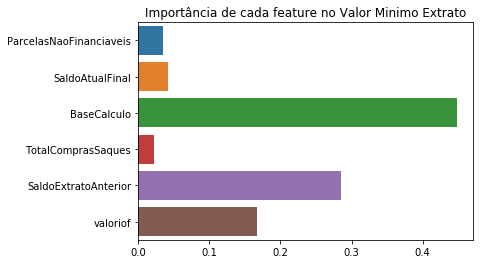

In [22]:
import seaborn as sns
importances = pd.Series(data=randomForestRegression.feature_importances_, index=preditoras)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature no Valor Minimo Extrato')

In [34]:
model_forest.predict([[0,124.20,0,124.2,174.05,0]])

array([26.])